In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import proylib

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:153: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  set_use_pygeos()
/tmp/ipykernel_68366/2259404774.py:5: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


2024-01-05 00:44:36 Configured OSMnx 1.1.2
2024-01-05 00:44:36 HTTP response caching is on


## Download data

### Guadalajara hexagons

In [2]:
schema = 'hexgrid'
folder = 'hexgrid_9_city_2020'

query = f"SELECT * FROM {schema}.{folder} WHERE \"CVEGEO\" = \'14039\'"

hex_gdf = proylib.gdf_from_query(query)
print(hex_gdf.shape)
hex_gdf.head(2)

(1214, 6)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,89498c95c87ffff,"POLYGON ((-103.29088 20.71405, -103.28966 20.7...",14039,Guadalajara,Guadalajara,urban
1,89498c94e8bffff,"POLYGON ((-103.32868 20.71718, -103.32746 20.7...",14039,Guadalajara,Guadalajara,urban


### Estructura urbana - Frente de manzana - Marco Geoestadístico

In [3]:
gdf_tmp = hex_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.set_geometry("geometry")
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [4]:
query = f"SELECT * FROM censo_urbano.censo_fm_2020 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
entorno = proylib.gdf_from_query(query, geometry_col='geometry')
print(entorno.shape)
entorno.head(4)

(60154, 68)


,CVEGEO2,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,CVEVIAL_x,CVESEG,CVEFT_x,NOMVIAL_x,...,ESTACIONBICI,ARBOLES,ALUMPUB,TELPUB,PUESTOSEMI,PUESTOAMBU,BANQUETA,GUARNICION,TAMLOC,VIANOESP
0,1403900013020053,14,039,0001,3020,053,09229,00002,2,Baron,...,3,3,1,3,3,3,1,1,11,0
1,1403900013533008,14,039,0001,3533,008,02513,00001,3,10,...,3,3,1,3,3,3,1,3,11,0
2,1403900013533013,14,039,0001,3533,013,02516,00001,4,15,...,3,3,3,3,3,3,1,3,11,0
3,1403900013533014,14,039,0001,3533,014,02418,00003,1,2,...,3,3,1,3,3,3,1,3,11,0


In [5]:
entorno.columns

Index(['CVEGEO2', 'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'CVE_AGEB', 'CVE_MZA',
       'CVEVIAL_x', 'CVESEG', 'CVEFT_x', 'NOMVIAL_x', 'TIPOVIAL', 'CVEVIAL1',
       'CVESEG1', 'CVEREF1', 'TIPOVR1', 'NOMREF1', 'CVEVIAL2', 'CVESEG2',
       'CVEREF2', 'TIPOVR2', 'NOMREF2', 'CVEVIAL3', 'CVESEG3', 'CVEREF3',
       'TIPOVR3', 'NOMREF3', 'geometry', 'CVEGEO', 'CVEGEOFTE', 'ID_FTE',
       'ID_MZA', 'ENT', 'MUN', 'LOC', 'AGEB', 'MZA', 'CVEFT_y', 'CVEVIAL_y',
       'NOMVIAL_y', 'NOMVIAL_C', 'TIPOVIAL_C', 'ESVIALIDAD', 'CLASEVIA',
       'CLASERASGO', 'OTRORASGO_C', 'RECUCALLE', 'RESTRICPEAT', 'RESTRICAUTO',
       'PASOPEAT', 'DRENAJEP', 'TRANSCOL', 'CICLOVIA', 'CICLOCARRIL',
       'LETRERO', 'RAMPAS', 'SEMAFOROPEAT', 'SEMAFOROAUDI', 'PARADATRANS',
       'ESTACIONBICI', 'ARBOLES', 'ALUMPUB', 'TELPUB', 'PUESTOSEMI',
       'PUESTOAMBU', 'BANQUETA', 'GUARNICION', 'TAMLOC', 'VIANOESP'],
      dtype='object')

## Urban structure analysis

In [6]:
ent_int = entorno.overlay(hex_gdf, how='intersection')
print(ent_int.shape)
ent_int.head(2)

(75713, 73)


,CVEGEO2,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,CVEVIAL_x,CVESEG,CVEFT_x,NOMVIAL_x,...,BANQUETA,GUARNICION,TAMLOC,VIANOESP,hex_id_9,CVEGEO_2,NOMGEO,city,type,geometry
0,1403900013020053,14,039,0001,3020,053,09229,00002,2,Baron,...,1,1,11,0,89498c94377ffff,14039,Guadalajara,Guadalajara,urban,"LINESTRING (-103.30607 20.72006, -103.30615 20..."
1,1403900013020045,14,039,0001,3020,045,09221,00003,3,Carlos E. Castillo Peraza,...,3,3,11,0,89498c94377ffff,14039,Guadalajara,Guadalajara,urban,"LINESTRING (-103.30758 20.72059, -103.30775 20..."


In [8]:
ent_int['length'] = ent_int.to_crs("EPSG:32613").length

In [9]:
urban_elements = ['BANQUETA','ALUMPUB','RAMPAS','ARBOLES',
                     'CICLOVIA']

for col in urban_elements:
    ent_tmp = ent_int.loc[(ent_int[col]==1)][['hex_id_9','length']].groupby(['hex_id_9']).sum()
    ent_tot = ent_int.loc[(ent_int[col]==1)|(ent_int[col]==3)][['hex_id_9','length']].groupby(['hex_id_9']).sum().reset_index().rename(columns={'length':                                                                                    'length_'+col})
    ent_tmp = ent_tmp.merge(ent_tot, on='hex_id_9')
    ent_tmp['pct_'+col] = ent_tmp['length'] / ent_tmp['length_'+col]
    ent_tmp = ent_tmp.drop(columns=['length','length_'+col])

    hex_gdf = hex_gdf.merge(ent_tmp, on='hex_id_9', how='left')

In [10]:
hex_gdf = hex_gdf.fillna(0)

<AxesSubplot: >

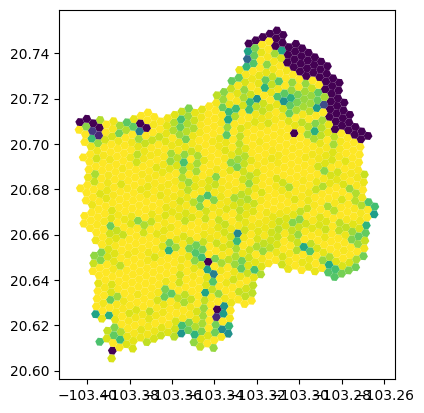

In [11]:
hex_gdf.plot('pct_BANQUETA')

<AxesSubplot: >

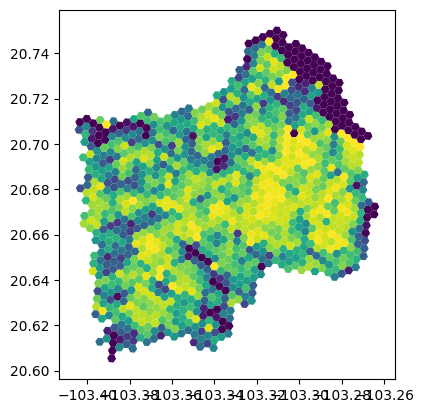

In [12]:
hex_gdf.plot('pct_RAMPAS')

<AxesSubplot: >

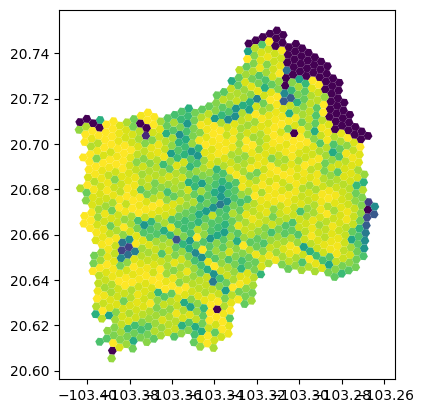

In [13]:
hex_gdf.plot('pct_ARBOLES')

<AxesSubplot: >

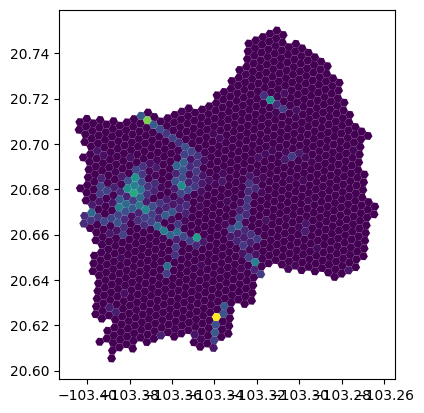

In [14]:
hex_gdf.plot('pct_CICLOVIA')

In [15]:
hex_gdf.to_file('../data/processed/hex_infraestructura.geojson')